In [12]:
from math import ceil
import numpy as np
from dragonn.models import SequenceDNN
import matplotlib.pyplot as plt

%matplotlib inline

SEQ_LEN = 145
STRIDE  = 29

In [2]:
def fragment_seq(seq):
    center = ceil(len(seq) / 2)
    shifts = int((center - SEQ_LEN / 2) / STRIDE)
    seqs = []
    for i in range(-shifts, shifts + 1):
        start = int(center + i*STRIDE - SEQ_LEN / 2)
        end   = int(center + i*STRIDE + SEQ_LEN / 2 + 1)
        
        seqs += [seq[start:end].upper()]
    return seqs


bases = ['A', 'T', 'C', 'G']

def one_hot_encode_seq(seq):
    if "N" in seq:
        seq = seq.replace("N", "A")
    result = np.zeros((len(bases), len(seq)))
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1
    return result
    
def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, len(bases), len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
            
    return result

In [5]:
seqs, coords = [], []
with open('../../data/dnase/hepg2.dnase.fa') as dnase:
    chrom = None
    for line in dnase:
        if line[0] == '>':
            if chrom:
                frags = fragment_seq(seq)
                seqs += frags
                coords += [(chrom, start, end, len(frags))]
            count, rest = line[1:].strip().split('::')
            chrom, rest = rest.split(':')
            start, end = map(int, rest.split('-'))
            seq = ''
        else:
            seq += line.strip()

In [6]:
X = seqs_to_encoded_matrix(seqs[:290000])
X.shape

(290000, 1, 4, 145)

In [7]:
import deeplift
from deeplift.conversion import keras_conversion as kc

model = SequenceDNN.load('../models/models/100n1_100n2_8w1_15w2.arch.json',
                         '../models/models/100n1_100n2_8w1_15w2.weights.h5')

deeplift_model = kc.convert_sequential_model(
                    model.model,
                    nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT)

deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=0,
                            target_layer_idx=-1)

In [8]:
scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[X],
                                         batch_size=128,
                                         progress_update=1000))
#np.save('deeplift.npy', scores)

No reference provided - using zeros
Done 0
Done 16000
Done 32000
Done 48000
Done 64000
Done 80000
Done 96000
Done 112000
Done 128000
Done 144000
Done 160000
Done 176000
Done 192000
Done 208000
Done 224000
Done 240000
Done 256000
Done 272000
Done 288000


In [9]:
# Map deeplift output back into genomic coordinates
seq_idx = 0
activity = {}
for chrom, start, end, num in coords:
    center = ceil((end - start) / 2)
    shifts = int((center - SEQ_LEN / 2) / STRIDE)
    begin = int(center - shifts*STRIDE - SEQ_LEN / 2)
    if seq_idx == 289991: break
    for i in range(num):
        s = scores[i+seq_idx].reshape(4, SEQ_LEN).T
        for j, nt in enumerate(s):
            if abs(min(nt)) > max(nt):
                act = min(nt)
            else:
                act = max(nt)   
            pos = start + begin + i * STRIDE + j
            
            if chrom not in activity:
                activity[chrom] = {}
            if pos not in activity[chrom]:
                activity[chrom][pos] = []
            activity[chrom][pos] += [act]
            
    seq_idx += num

IndexError: index 290000 is out of bounds for axis 0 with size 290000

In [123]:
counts = []
for chrom, start, end, num in coords[:2000]:
    center = ceil((end - start) / 2)
    shifts = int((center - SEQ_LEN / 2) / STRIDE)
    begin = int(center - (shifts-4)*STRIDE - SEQ_LEN / 2)
    stop  = int(center + (shifts-4)*STRIDE + SEQ_LEN / 2)

    acts = [np.mean((activity[chrom][pos+start][2:3])) for pos in range(begin, stop)]
    
    counts += [acts]

c = np.vstack(counts)

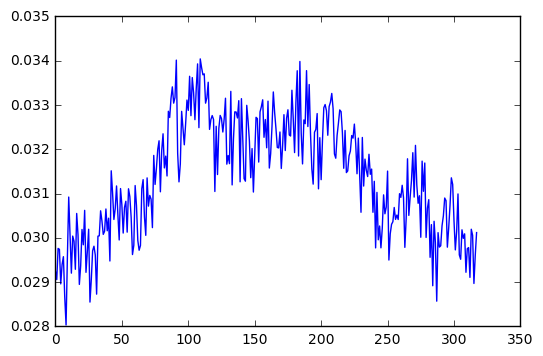

In [124]:
plt.plot(np.abs(c).mean(axis = 0))
plt.show()

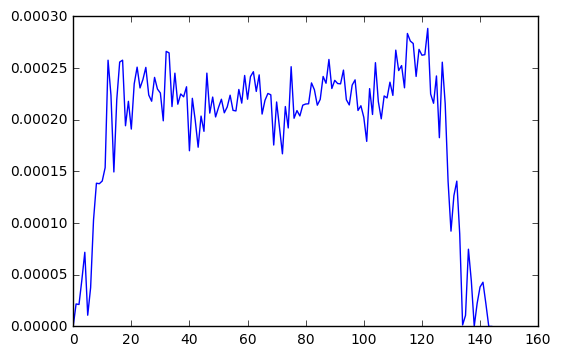

In [122]:
plt.plot(scores.mean(axis = 2).reshape(290000, 145).mean(axis = 0))
plt.show()

In [32]:
seqs2, coords2 = [], []
with open('../../data/dnase/k562.dnase.fa') as dnase:
    chrom = None
    for line in dnase:
        if line[0] == '>':
            if chrom:
                frags = fragment_seq(seq)
                seqs2 += frags
                coords2 += [(chrom, start, end, len(frags))]
            count, rest = line[1:].strip().split('::')
            chrom, rest = rest.split(':')
            start, end = map(int, rest.split('-'))
            seq = ''
        else:
            seq += line.strip()
X2 = seqs_to_encoded_matrix(seqs2[:290000])
X2.shape

(290000, 1, 4, 145)

In [33]:
pred = model.predict(X)
pred2 = model.predict(X2)

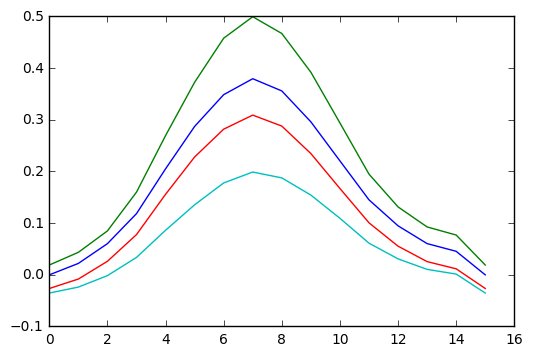

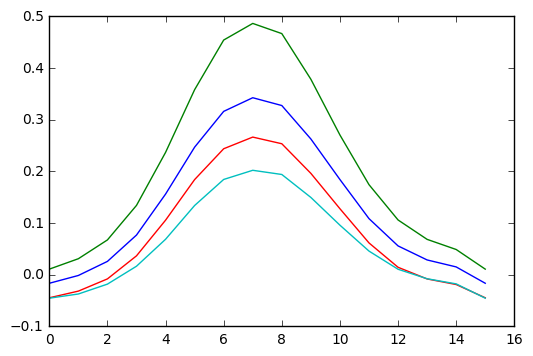

In [77]:
plt.plot([pred[range(i, 200000, 15)].mean(axis = 0) for i in range(16)])
plt.show()
plt.plot([pred2[range(i, 200000, 15)].mean(axis = 0) for i in range(16)])
plt.show()

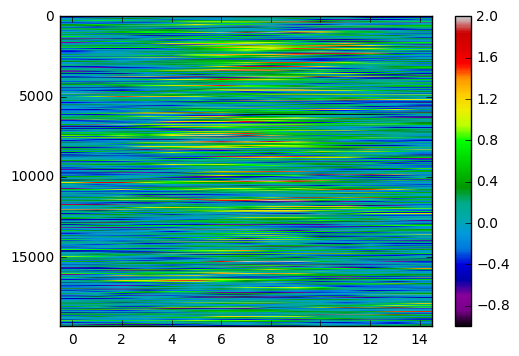

In [86]:
hm = plt.imshow(pred[:289995, 0].reshape(289995 / 15, 15), aspect = 'auto', cmap = 'nipy_spectral')
plt.colorbar(hm)
plt.clim(2, -1)
plt.show()

In [170]:
scores[0].shape

(1, 4, 145)

In [126]:
# Loads in SHARPR activity scores
sharpr = {}
for promoter in ('minP',):
    for cell_type in ('HEPG2',):
        experiment_key = (promoter, cell_type)
        sharpr[experiment_key] = {}
        with open("../../data/sharpr_scores/wig/{}_{}.wig".format(promoter, cell_type)) as wig:
            for line in wig:
                if line[0] == '#': continue
                chrom, start, end, score = line.strip().split()
                start, end = int(start), int(end)
                score = float(score)
                if end - start > 1: continue
                if chrom not in sharpr[experiment_key]: sharpr[experiment_key][chrom] = {}
                for pos in range(start, end):
                    assert pos not in sharpr[experiment_key][chrom]
                    sharpr[experiment_key][chrom][pos] = score

In [127]:
sharpr = sharpr[sharpr.keys()[0]]

In [144]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
s, d = [], []
pairs = []
missing = 0
for chrom, positions in activity.items():
    for pos, score in positions.items():
        if len(score) < 5: continue
        score = sum(score[2:3]) / float(len(score[2:3]))
        try:
            s += [sharpr[chrom][int(pos)]]
            d += [score]
            pairs += [(s[-1], d[-1])]
        except KeyError:
            missing += 1
print missing


5939455


0.111514172325 0.0


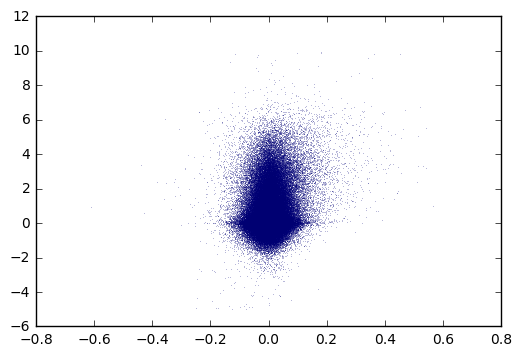

0.534250506925 3.73507165161e-244


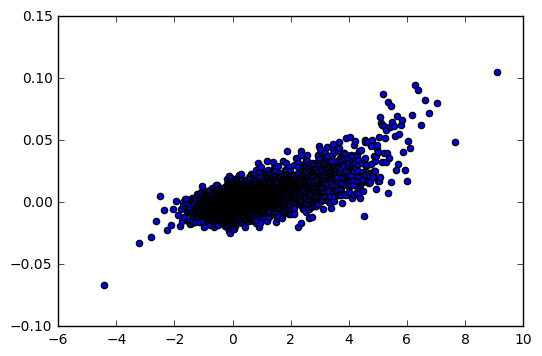

In [145]:
rho, pval = spearmanr(s, d)
print rho, pval
plt.scatter(d, s, lw = 0, s = .1)
#plt.plot(np.unique(s), np.poly1d(np.polyfit(s, d, 1))(np.unique(s)), c='r', linewidth=3)
plt.show()
quantile_plot(pairs, 5000)

In [139]:
# Load in the data.
si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
with open('../../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt') as conservation:
    for line in conservation:
        chrom, start, end, lor, branch = line.strip().split()
        start, end, lor = int(start), int(end), float(lor)
        if chrom not in activity: continue
        if chrom not in si_phi: si_phi[chrom] = {}
        if (start not in activity[chrom]
            and end not in activity[chrom]): continue
        for pos in range(start, end):
            si_phi[chrom][pos] = 1

IOError: [Errno 2] No such file or directory: '../../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt'

In [140]:
deep_conserve = []
for chrom, positions in activity.items():
    for pos, score in positions.items():
        if len(score) < 5: continue
        score = sum(score[:5]) / float(len(score[:5]))
        deep_conserve.append((score, si_phi[chrom][pos] if pos in si_phi[chrom] else 0))

KeyError: 'chrY'

In [129]:
def quantile_plot(data_pairs, quantiles = 5000):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    i = 0
    while avg_activity[i] < 0: i += 1
    rho, pval = spearmanr(avg_activity[i:], avg_score[i:])
    print rho, pval
    plt.scatter(avg_activity, avg_score)
    plt.show()

0.591852154634 2.29596470573e-232


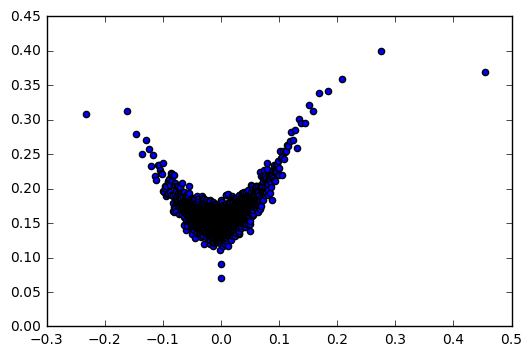

In [247]:
quantile_plot(deep_conserve, 5000)

In [147]:
hepG2_centipede = {}
with open('../../data/centipede/HEPG2_liftover.bed') as regions:
    regions.readline()
    for line in regions:
        chrom, start, end, motif = line.strip().split()[:4]
        start, end = int(start), int(end)
        if chrom not in hepG2_centipede: hepG2_centipede[chrom] = {}
        for pos in range(start, end):
            hepG2_centipede[chrom][pos] = motif

In [155]:
deep_centipede = []
for chrom, positions in activity.items():
    for pos, score in positions.items():
        if len(score) < 5: continue
        score = sum(score) /float(len(score))
        motif = 1 if pos in hepG2_centipede[chrom] else 0
        deep_centipede.append((score, motif))

0.877395845633 0.0


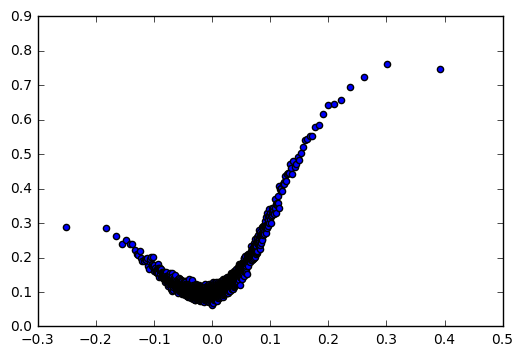

In [159]:
quantile_plot(deep_centipede)

In [157]:
len(deep_centipede)

6100666